Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2556 - accuracy: 0.9269
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1136 - accuracy: 0.9667
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0792 - accuracy: 0.9763
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0590 - accuracy: 0.9821
Epoch 5/5
1/1 [==============================] - 0s 12ms/step
Original Image Prediction: 7
Adversarial Image Prediction: 3
Original Label: 7
Adversarial Test Accuracy: 0.03009999915957451
Regular Test Accuracy: 0.9742000102996826


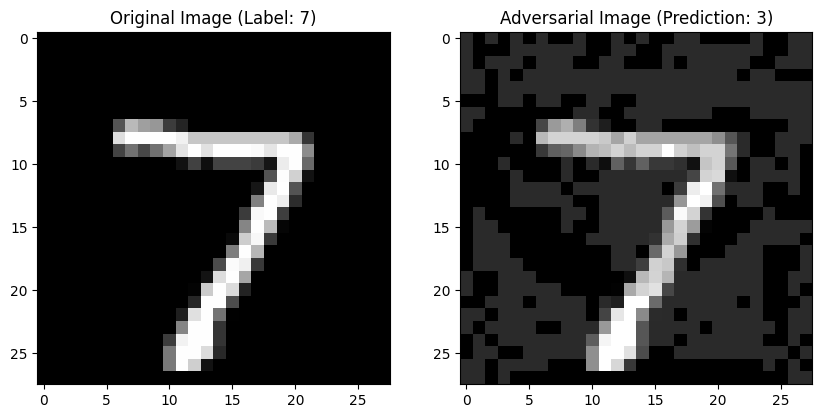

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist

# 1. Load and Preprocess Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

# 2. Build a Simple Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 3. Train the Model
model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)

# 4. Generate Adversarial Examples (Fast Gradient Sign Method - FGSM)
def generate_adversarial_example(model, image, label, epsilon=0.1):
    image = tf.convert_to_tensor(image[np.newaxis, :])
    label = tf.convert_to_tensor(label)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(label, prediction) #change here

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adversarial_image = image + epsilon * signed_grad
    return adversarial_image.numpy().reshape(784)

# 5. Create an Adversarial Example
sample_image = x_test[0]
sample_label = y_test[0]

adversarial_example = generate_adversarial_example(model, sample_image, sample_label)

# 6. Evaluate the Model on the Adversarial Example
original_prediction = model.predict(sample_image[np.newaxis, :])
adversarial_prediction = model.predict(adversarial_example[np.newaxis, :])

print(f"Original Image Prediction: {np.argmax(original_prediction)}")
print(f"Adversarial Image Prediction: {np.argmax(adversarial_prediction)}")
print(f"Original Label: {sample_label}")

# 7. Evaluate Model Accuracy on Adversarial Test Set.
adversarial_test_set = np.array([generate_adversarial_example(model, x, y) for x, y in zip(x_test, y_test)])

_, adversarial_accuracy = model.evaluate(adversarial_test_set, y_test, verbose=0)
print(f"Adversarial Test Accuracy: {adversarial_accuracy}")

_, regular_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Regular Test Accuracy: {regular_accuracy}")

# 8. Visualizing the results (optional, requires matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.title(f"Original Image (Label: {sample_label})")

plt.subplot(1, 2, 2)
plt.imshow(adversarial_example.reshape(28, 28), cmap='gray')
plt.title(f"Adversarial Image (Prediction: {np.argmax(adversarial_prediction)})")

plt.show()
